<a href="https://colab.research.google.com/github/m-shilpa/Transformer_Memory_As_A_Differentiable_Search_Index/blob/main/IR_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# to prevent logs of installation use %%capture
%%capture  
!pip install transformers[sentencepiece]
!pip install nlp
!pip install pytorch-lightning


In [3]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import string
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from nlp import load_metric

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
import random
import re
from pathlib import Path
from datetime import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [4]:
df = pd.read_csv(f'/content/gdrive/MyDrive/IR/data_100K_clipped_documents_1k_words.csv',nrows=50000)

In [5]:
print('Records where doc_id is null',len(df[df['doc_id'].isna()==True]))
doc_url_map = df[['doc_id','document_url']]
df = df[['doc_id','document_text',  'question_text' ]]
df['doc_id'] = df['doc_id'].astype('str')

Records where doc_id is null 0


In [6]:
df.shape

(50000, 3)

In [7]:
data_len = len(df)

# Data Preparation and Training

In [8]:
model_name = "t5-small"
token_len = 512
model_prefix = f"{model_name}-{token_len}"

In [9]:
import copy

def chunk(indices, chunk_size):
    return torch.split(torch.tensor(indices), chunk_size)

class Sampler():
    def __init__(self, index_lists,batch_size):
        '''
        The description of the args is as below:
            index_lists is a list of lists of indexes. eg. [[1,2,3,4],[5,6,7,8]]
            batch_size is the size of the batches that need to be created.
        '''
        self.index_lists = index_lists
        self.batch_size = batch_size

    def __iter__(self):
        '''
        This function creates batches of indexes.
        For each list in the index_list, the batch is created.
        eg. index_list = [[1,2,3,4],[5,6,7,8]], batch_size = 2
            the result batches will be [(1,2),(3,4),(5,6),(7,8)]
        '''

        index_lists = copy.deepcopy(self.index_lists)       
        res = []
        for cl in index_lists:
            random.shuffle(cl)
            gp = chunk(cl, self.batch_size)
            for j in gp:
                res.append(j.tolist())


        return iter(res)


In [10]:
class NQData(Dataset):
    # task_type is either 'indexing' or 'retrival' or 'indexing_retrival'
    def __init__(self, df, tokenizer, type_path, num_samples, task_type,input_length=4096,
                 output_length=4096, print_text=False):         
        
        ## Shuffle data set
        df = df.sample(frac=1, random_state=1)
        self.dataset = []
        self.task_type = task_type
        self.indexing_task_name = 'indexing'
        self.retrival_task_name ='retrival'
        self.retrival_str_max_len = 20
 
        self.indexing_str_max_len = output_length
        
        sep = int(len(self.dataset)/2)
   
        
        val_size = int(0.2 * len(df))
        

        if task_type == self.indexing_task_name:
           
            self.indices = [[]]
   
            self.dataset = self.get_dataset_list(data=df,
                                                    type_path=type_path,
                                                    col='document_text',
                                                    task_name=self.indexing_task_name,
                                                    split_size=val_size,
                                                    splits=True
                                                )
            self.indices[0].extend(list(range(len(self.dataset))))

        elif task_type == self.retrival_task_name:
            
            self.indices = [[]]
            self.dataset = self.get_dataset_list(data=df,
                                                    type_path=type_path,
                                                    col='question_text',
                                                    task_name=self.indexing_task_name,
                                                    split_size=val_size,
                                                    splits=True
                                                 )
            self.indices[0].extend(list(range(len(self.dataset))))

        elif task_type == 'indexing_retrival':
            inp_cols = ['document_text','question_text']
            self.indices = [[] for _ in range(len(inp_cols))]
           
            for idx, col in enumerate(inp_cols):
                length = len(self.dataset)

                if col == 'document_text':
                                   
                    dataset = self.get_dataset_list(data=df,
                                                    type_path=type_path,
                                                    col=col,
                                                    task_name=self.indexing_task_name,
                                                    split_size=val_size,
                                                    splits=False)
                else:
                    
                    dataset = self.get_dataset_list(data=df,
                                                    type_path=type_path,
                                                    col=col,
                                                    task_name=self.retrival_task_name,
                                                    split_size=val_size,
                                                    splits=True)
                
                self.dataset.extend(dataset)
                
             
                self.indices[idx].extend(list(range(length, len(self.dataset) )))

        if num_samples:
            self.dataset = self.dataset[:num_samples]
        
      

        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text

    def get_dataset_list(self,data,type_path,col,task_name,split_size,splits):

       
        dataset = []  
        
        d1 = data[[col,'doc_id']]
        
        if splits :
            if type_path == "train":
                d1 = d1.iloc[split_size :]
            else:
                d1 = d1.iloc[:split_size]
        
        d1[col] = task_name +': ' + d1[col]

        d1.columns = ['inp','lbl']
        dataset.extend(d1.to_dict(orient='records'))  
        return dataset

    def get_index_list(self):
        
        return self.indices
        
  
    def __len__(self):

        return len(self.dataset)

    def convert_to_features(self, example_batch):
       
        
        input_ = example_batch['inp']
        target_ = example_batch['lbl']
        if example_batch['inp'].startswith(self.retrival_task_name):
            max_length = self.retrival_str_max_len
        else:
            max_length = self.indexing_str_max_len
        
        input_ = input_.strip()

        
        source = self.tokenizer.batch_encode_plus([input_], max_length= max_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=3, 
                                                     padding='max_length', truncation=True, return_tensors="pt")

        return source, targets
  
    def __getitem__(self, index):
      

        source, targets = self.convert_to_features(self.dataset[index])
        
        
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        if self.print_text:
            print("Lens are: ", source['input_ids'][0].shape, targets['input_ids'][0].shape)
           

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}



def get_dataset(tokenizer, type_path, num_samples, task_type, args, df=df):
      return NQData(df=df, tokenizer=tokenizer, type_path=type_path, num_samples=num_samples, 
                    task_type=task_type, input_length=args.max_input_length, 
                        output_length=args.max_output_length)      

In [11]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix((remove_punc(lower(s))))

In [12]:
def exact_match_score(prediction, ground_truth):
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))

In [13]:
def calculate_scores(predictions, ground_truths):
    em_score = 0
    subset_match_score = 0
    
    for i in range(len(predictions)):
        ground_truth = ground_truths[i]
        prediction = predictions[i]
        em_score +=  exact_match_score(prediction, ground_truth)
    
    em_score /= len(predictions)
    return em_score*100

In [14]:
def save_metrics(save_path, epoch_metric_val_tuple, metric_name):
   
    if os.path.exists(save_path):
        header = False
    else:
        header = True
    
    tmp = pd.DataFrame([epoch_metric_val_tuple], columns=['epoch','value'])
    tmp['metric'] = metric_name
    tmp['timestamp'] = datetime.now()
    tmp.to_csv(save_path, mode='a',header=header, index=False)

In [15]:
class NQ_IR(pl.LightningModule):
    def __init__(self, hparams):
        super(NQ_IR, self).__init__()
        self.save_hyperparameters(hparams)
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path, return_dict=True)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path, max_length=hparams.max_input_length)
        self.output_dir = Path(self.hparams.output_dir)
        self.step_count = 0

        # https://github.com/huggingface/transformers/blob/main/examples/legacy/seq2seq/finetune_trainer.py
        if self.hparams.freeze_embeds:
            self.freeze_embeds()
        if self.hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
           
            
        n_observations_per_split = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test,
        }
        self.n_obs = {k: v if v >= 0 else None for k, v in n_observations_per_split.items()}
        self.em_score_list = []
 
        
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
    def freeze_embeds(self):
        try:
            self.freeze_params(self.model.model.shared)
            for d in [self.model.model.encoder, self.model.model.decoder]:
                freeze_params(d.embed_positions)
                freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)

    def lmap(self, f, x):
        return list(map(f, x))

    def is_logger(self):
        return self.trainer.global_rank <= 0
    
    def parse_score(self, result):
        return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}
        
    def forward(self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None):
        
        return self.model(
                input_ids,
                attention_mask=attention_mask,
                decoder_input_ids=decoder_input_ids,
                decoder_attention_mask=decoder_attention_mask,
                labels=lm_labels
            )

    def _step(self, batch):
        labels = batch["target_ids"]
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids,
            skip_special_tokens=True, 
            clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        # print(batch)
        inp_ids = batch["source_ids"]
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=3

        )
        preds = self.ids_to_clean_text(generated_ids)
        target = self.ids_to_clean_text(batch["target_ids"])
        
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target)
        em_score  = calculate_scores(preds, target)
        
        self.em_score_list.append(em_score)
        
        em_score = torch.tensor(em_score,dtype=torch.float32)
    
        base_metrics.update(accuracy=em_score)
        
        return base_metrics

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}

        # the below returned dictionary is accessed in the train_epoch_end method
        return {"loss": loss, "log": tensorboard_logs}
  
    def training_epoch_end(self, outputs):
       
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
       
        self.log("avg_train_loss", avg_train_loss)

        train_losses = (self.trainer.current_epoch,avg_train_loss.item())
        save_metrics(save_path=self.hparams.log_dir, epoch_metric_val_tuple=train_losses, metric_name='train_losses')

        lr_vals = (self.trainer.current_epoch,self.lr_scheduler.get_last_lr()[-1])
        save_metrics(save_path=self.hparams.log_dir, epoch_metric_val_tuple=lr_vals, metric_name='lr')

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
    def validation_epoch_end(self, outputs):

        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        # tensorboard_logs = {"val_loss": avg_loss}
        
        if len(self.em_score_list) <= 2:
            average_em_score = sum(self.em_score_list) / len(self.em_score_list) 
            
        else:
            latest_em_score = self.em_score_list[:-2]
            average_em_score = sum(latest_em_score) / len(latest_em_score) 
        
        average_em_score = torch.tensor(average_em_score,dtype=torch.float32)
        # tensorboard_logs.update(accuracy=average_em_score)
        
        self.target_gen= []
        self.prediction_gen=[]

        # self.log creates the lightening folder and stores the logs. 
        # This self.log dict is used by the ModelCheckpoint for find the model that fits the checking criteria.
        # So in ModelCheckpointing, if moniter= 'avg_val_loss' and  mode='min' then the 'avg_val_loss' in the self.loss is looked at to get model with min avg_val_loss
        self.log("avg_val_loss", avg_loss) 
        self.log("val_accuracy" , average_em_score)

        val_losses = (self.trainer.current_epoch,avg_loss.item())
        save_metrics(save_path=self.hparams.log_dir, epoch_metric_val_tuple=val_losses, metric_name='val_losses')

        val_accuracies = (self.trainer.current_epoch,average_em_score.item())
        save_metrics(save_path=self.hparams.log_dir, epoch_metric_val_tuple=val_accuracies, metric_name='val_accuracies')
        # self.val_losses.append((self.trainer.current_epoch,avg_loss.item()))
        # self.val_accuracies.append((self.trainer.current_epoch,average_em_score.item()))

        
       


    def configure_optimizers(self):

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]
  
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    
    def train_dataloader(self):   
        
        n_samples = self.n_obs['train']
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train",task_type ='indexing_retrival', num_samples=n_samples, args=self.hparams)
        dataloader = DataLoader(train_dataset,
                                batch_sampler=Sampler(train_dataset.get_index_list(),self.hparams.train_batch_size),
                                num_workers=2
                                )
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler

        return dataloader

    def val_dataloader(self):
        n_samples = self.n_obs['validation']
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation",task_type ='indexing_retrival', num_samples=n_samples, args=self.hparams)
        
        return DataLoader(validation_dataset, 
                          batch_sampler=Sampler(validation_dataset.get_index_list(),self.hparams.eval_batch_size),num_workers=2)
    
    def test_dataloader(self):
        n_samples = self.n_obs['test']
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test",task_type ='retrival', num_samples=n_samples, args=self.hparams)
        
        return DataLoader(test_dataset, 
                          batch_sampler=Sampler(test_dataset.get_index_list(),self.hparams.eval_batch_size),
                          num_workers=2)
    
    # def on_save_checkpoint(self, checkpoint):
    #     save_path = self.output_dir.joinpath(model_prefix)
    #     self.model.config.save_step = self.step_count
    #     self.model.save_pretrained(save_path)
    #     self.tokenizer.save_pretrained(save_path)



In [17]:
import os
checkpoints_dir = '/content/gdrive/MyDrive/IR/t5-small-512_50000_rows_checkpoint/'
checkpoint_files = os.listdir(checkpoints_dir)

if len(checkpoint_files)==0:
    resume_from_checkpoint_path = None
    raise Exception('No checkpoint found')

else:
    resume_from_checkpoint_path = checkpoints_dir  + checkpoint_files[-1]

print(resume_from_checkpoint_path)

/content/gdrive/MyDrive/IR/t5-small-512_50000_rows_checkpoint/epoch=29-step=168750.ckpt


In [18]:

log_dir = "/content/gdrive/MyDrive/IR/logs/log_t5-small-512_50000_rows_2022_05_01_13_07_19.csv"
print('Log file path:', log_dir)

args_dict = dict(
    output_dir=f"./{model_prefix}_{str(data_len)}_rows_final", # path to save the checkpoints
    log_dir = log_dir,
    model_name_or_path=model_name,
    tokenizer_name_or_path=model_name,
    max_input_length=token_len,
    max_output_length=token_len,
    freeze_encoder=False,
    freeze_embeds=False,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=16,
    eval_batch_size=16,
    num_train_epochs=30,
    gradient_accumulation_steps=1,
    n_gpu=1,
    resume_from_checkpoint_path=resume_from_checkpoint_path, 
    val_check_interval = 1, 
    check_val_every_n_epoch = 1,
    n_val=-1,
    n_train=-1,
    n_test=-1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    # opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)



args = argparse.Namespace(**args_dict)


## Define Checkpoint function
# monitor - monitors the metric and saves the chekpoint with the mode value. Here mode=max so saves the checkpoint with max metric value.
# save_top_k saves lastest k checkpoints
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=f"/content/gdrive/MyDrive/IR/{model_prefix}_{str(data_len)}_rows_checkpoint", 
                                                    monitor="avg_val_loss", mode="min", save_top_k=1) 


# accumulate_grad_batches stores the gradients for a set of batches and then updates the model params. 
    # So if batch size=8 and accumulate_grad_batches= 2 then the gradients are accumulated for 2 batches and the model params are updated only at the end of the 2nd batch.
    # The default was to update the model params at the end of each batch

train_params = dict(
    # accumulate_grad_batches=args.gradient_accumulation_steps, # with this, total batchsize= batchsize* accumulate_grad_batches
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    precision= 16 if args.fp_16 else 32,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    check_val_every_n_epoch=args.check_val_every_n_epoch,
    callbacks=[checkpoint_callback] ,  #[LoggingCallback()],

    # logger=wandb_logger,
    # val_check_interval=args.val_check_interval,
    # amp_level=args.opt_level,
    # resume_from_checkpoint=args.resume_from_checkpoint, # depreciated
    # progress_bar_refresh_rate=0
    # log_every_n_steps=1
)




Log file path: /content/gdrive/MyDrive/IR/logs/log_t5-small-512_50000_rows_2022_05_01_13_07_19.csv


In [19]:
trainer_fit_params=dict(ckpt_path=args.resume_from_checkpoint_path, # to resume from this checkpoint
                        
)

In [20]:

model = NQ_IR(args)


Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [21]:
trainer = pl.Trainer(**train_params, fast_dev_run=False)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fc1aa575fd0>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fc1aa575fd0>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model,**trainer_fit_params)

Missing logger folder: /content/lightning_logs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/gdrive/MyDrive/IR/t5-small-512_50000_rows_checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at /content/gdrive/MyDrive/IR/t5-small-512_50000_rows_checkpoint/epoch=29-step=168750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
trainer.current_epoch

30

In [30]:
import matplotlib.pyplot as plt

In [133]:
logs = pd.read_csv(log_dir)

In [134]:
logs.shape

(168, 4)

In [162]:
# In pytorch-lightning, the model first runs on the validation dataset, hence there'll be multiple validation logs for same epoch. 
# Below, we are removing the additional validation logs 

logs1 = pd.merge(logs[logs['metric']=='train_losses'][['epoch','timestamp']], 
                 logs[logs['metric']=='val_losses'],
                 on=['epoch'],
                 how='inner'
                 )
logs1['timestamp_x'] = logs1['timestamp_x'].astype('datetime64[s]').values.astype('<M8[m]')
logs1['timestamp_y'] = logs1['timestamp_y'].astype('datetime64[s]').values.astype('<M8[m]')
logs1 = logs1[logs1['timestamp_x']==logs1['timestamp_y']]
logs1.drop(['timestamp_y'],axis=1, inplace=True)
logs1.rename(columns={'timestamp_x':'timestamp'}, inplace=True)

In [163]:
logs2 = pd.merge(logs[logs['metric']=='train_losses'][['epoch','timestamp']], 
                 logs[logs['metric']=='val_accuracies'],
                 on=['epoch'],
                 how='inner'
                 )
logs2['timestamp_x'] = logs2['timestamp_x'].astype('datetime64[s]').values.astype('<M8[m]')
logs2['timestamp_y'] = logs2['timestamp_y'].astype('datetime64[s]').values.astype('<M8[m]')
logs2 = logs2[logs2['timestamp_x']==logs2['timestamp_y']]
logs2.drop(['timestamp_y'],axis=1, inplace=True)
logs2.rename(columns={'timestamp_x':'timestamp'}, inplace=True)

In [165]:
logs_val_losses = logs1[logs1['metric']=='val_losses'].sort_values(['epoch','timestamp']).drop_duplicates(['epoch'], keep='last')
logs_val_accuracies = logs2[logs2['metric']=='val_accuracies'].sort_values(['epoch','timestamp']).drop_duplicates(['epoch'], keep='last')
logs_train_losses = logs[logs['metric']=='train_losses']
logs_lr = logs[logs['metric']=='lr']

No handles with labels found to put in legend.


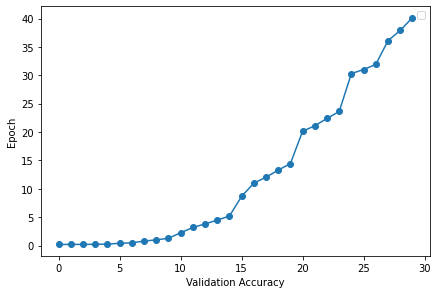

In [179]:
plt.plot(logs_val_accuracies['epoch'],logs_val_accuracies['value'],marker='o')
plt.tight_layout()
plt.xlabel("Validation Accuracy")
plt.ylabel("Epoch")
plt.legend()

No handles with labels found to put in legend.


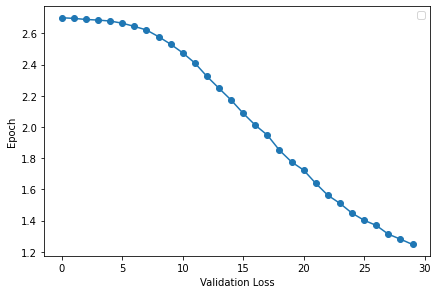

In [180]:
plt.plot(logs_val_losses['epoch'],logs_val_losses['value'],marker='o')
plt.tight_layout()
plt.xlabel("Validation Loss")
plt.ylabel("Epoch")
plt.legend()

No handles with labels found to put in legend.


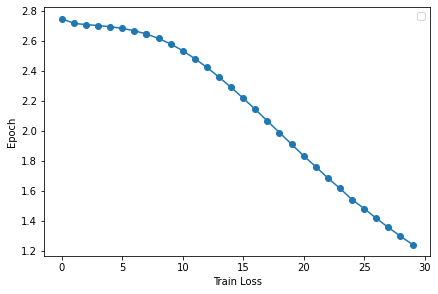

In [181]:
plt.plot(logs_train_losses['epoch'],logs_train_losses['value'],marker='o')
plt.tight_layout()
plt.xlabel("Train Loss")
plt.ylabel("Epoch")
plt.legend()

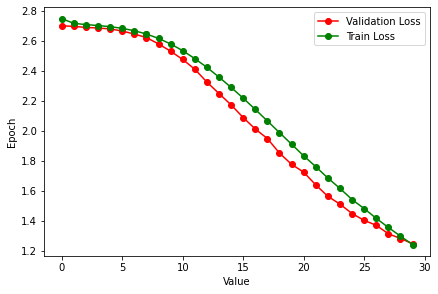

In [176]:
plt.plot(logs_val_losses['epoch'],logs_val_losses['value'], c='red',marker='o', label = "Validation Loss")
plt.plot(logs_train_losses['epoch'],logs_train_losses['value'], c='green',marker='o', label = "Train Loss")
plt.tight_layout()
plt.xlabel("Value")
plt.ylabel("Epoch")
plt.legend()

No handles with labels found to put in legend.


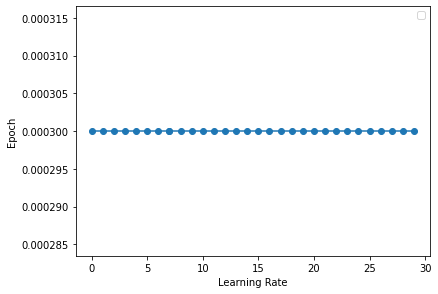

In [182]:
plt.plot(logs_lr['epoch'],logs_lr['value'],marker='o')
plt.tight_layout()
plt.xlabel("Learning Rate")
plt.ylabel("Epoch")
plt.legend()